# Boiler Aufheizkurve

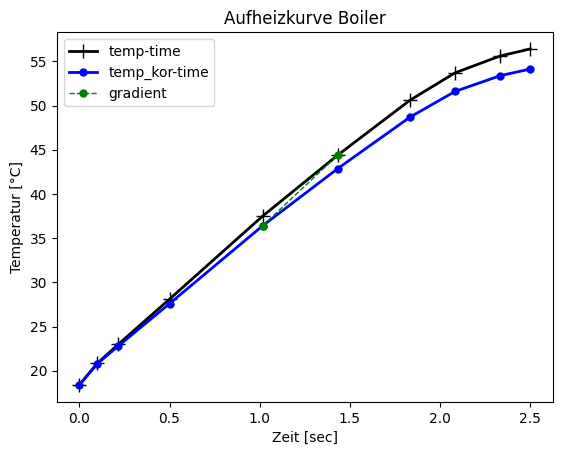

In [173]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal


time_meas_s   = np.array([0,6,13,30,61,86,110,125,140,150])*60.
temp_meas_deg = np.array([18.4,20.85,23.0,28.1,37.5,44.4,50.6,53.7,55.6,56.4])

P = 2000
temp_wand = 20.

dtemp_vec = np.empty(shape=(time_meas_s.size, 1), dtype=float)
dtemp_kor_vec = np.empty(shape=(time_meas_s.size, 1), dtype=float)
temp_kor_vec= np.empty(shape=(time_meas_s.size, 1), dtype=float)

temp_kor_vec[0] = temp_meas_deg[0]

for i in range(1,time_meas_s.size):
  delta_temp = temp_meas_deg[i]-temp_meas_deg[i-1]
  delta_time = time_meas_s[i]-time_meas_s[i-1]
  dtemp_vec[i] = delta_temp/delta_time


  # Mischtemperatur mit 5 l mit 13 °C
  temp_kor_vec[i] = (75.*temp_meas_deg[i]+5*temp_wand)/80

  delta_kor_temp   = temp_meas_deg[i]-temp_kor_vec[i-1]
  dtemp_kor_vec[i] = delta_kor_temp/delta_time

  # print(f"dtemp_vec[{i}] {dtemp_vec[i]}, dtemp_kor_vec[{i}] {dtemp_kor_vec[i]}, quot = {dtemp_kor_vec[i]/dtemp_vec[i]}")

dtemp_vec[0] = dtemp_vec[1]  
dtemp_kor_vec[0] = dtemp_kor_vec[1] 

# a = np.empty(shape=(25, 2), dtype=int)
# for x in range(1, 6):
#     for y in range(1, 6):
#         index = (x-1)*5+(y-1)
#         a[index] = x, y

time_grad_vec = np.empty(shape=(2, 1), dtype=float)
temp_grad_vec = np.empty(shape=(2, 1), dtype=float)

time_grad_vec[0] = time_meas_s[4]
time_grad_vec[1] = time_meas_s[5]
temp_grad_vec[0] = temp_kor_vec[4]
temp_grad_vec[1] = temp_meas_deg[5]

plt.plot(time_meas_s/60./60.,temp_meas_deg,color='#000000',linestyle='-',linewidth=2,marker='+',markersize=10,label='temp-time')
plt.plot(time_meas_s/60./60.,temp_kor_vec,color='b',linestyle='-',linewidth=2,marker='o',markersize=5,label='temp_kor-time')
plt.plot(time_grad_vec/60./60.,temp_grad_vec,color='g',linestyle='--',linewidth=1,marker='o',markersize=5,label='gradient')

plt.title('Aufheizkurve Boiler')
plt.xlabel('Zeit [sec]')
plt.ylabel('Temperatur [°C]')
plt.legend()
plt.show()

In [174]:
# dy/dt(t) + a * y(t) = b * u(t)
#
# +-          -+   +-               -+   +- -+
# | dy/dt(i)   |   | -y(i)    u(i)   | * | a |
# | dy/dt(i+1) | = | -y(i+1)  u(i+1) | * | b |
# | dy/dt(i+2) |   | -y(i+2)  u(i+2) |   +- -+
# +-          -+   +-               -+

y = np.empty(shape=(time_meas_s.size, 1), dtype=float)
A = np.empty(shape=(time_meas_s.size, 2), dtype=float)
x = np.empty(shape=(2, 1), dtype=float)

for i in range(0,time_meas_s.size):
  y[i] = dtemp_kor_vec[i]
  A[i] = -(temp_meas_deg[i]-temp_meas_deg[0]), P


B = A.conj().transpose()
AA = B @ A
yy = B @ y
x = np.linalg.lstsq(AA, yy, rcond=None)

x = np.linalg.inv(AA) @ yy

a = x[0][0]*0.1      # etwa 1/10 korrigiert aus Abschätzung Abkühlen
b = x[1][0]*0.965

print("dT/dt(t) + a * T(t) = b * P(t)")
print("------------------------------")
print(f"a = {a}")
print(f"b = {b}")
print("------------------------------")



dT/dt(t) + a * T(t) = b * P(t)
------------------------------
a = 3.334419488648185e-06
b = 2.9887601854643333e-06
------------------------------


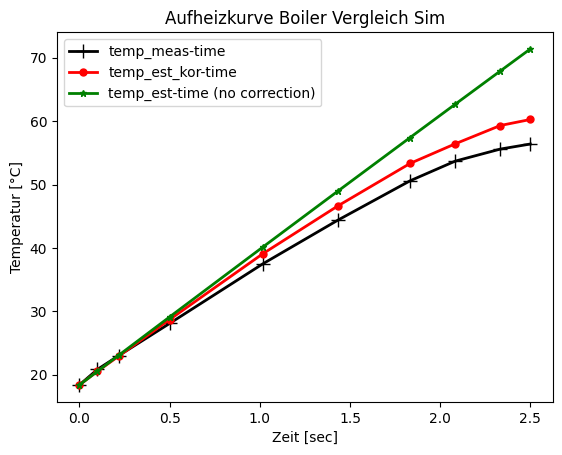

In [175]:
temp_est     = np.empty(shape=(time_meas_s.size, 1), dtype=float)
temp_est_kor = np.empty(shape=(time_meas_s.size, 1), dtype=float)
temp_est_kor[0] = 0.
temp_est[0] = 0.
temp_est_kor_stern = 0.



for i in range(1,time_meas_s.size):

  e = np.exp(-a*(time_meas_s[i]-time_meas_s[i-1]))
  temp_est_kor[i] = e * temp_est_kor_stern +  P * b /a *(1. - e ) 

  # Mischtemperatur mit 5 l mit 18.4 °C
  temp_est_kor_stern = (75.*(temp_est_kor[i]+temp_meas_deg[0])+5*temp_meas_deg[0])/80
  temp_est_kor_stern -= temp_meas_deg[0]

  temp_est[i] = e * temp_est[i-1] +  P * b /a *(1. - e ) 


temp_est_kor += temp_meas_deg[0]
temp_est     += temp_meas_deg[0]

plt.plot(time_meas_s/60./60.,temp_meas_deg,color='#000000',linestyle='-',linewidth=2,marker='+',markersize=10,label='temp_meas-time')
plt.plot(time_meas_s/60./60.,temp_est_kor,color='r',linestyle='-',linewidth=2,marker='o',markersize=5,label='temp_est_kor-time')
plt.plot(time_meas_s/60./60.,temp_est,color='g',linestyle='-',linewidth=2,marker='*',markersize=5,label='temp_est-time (no correction)')

plt.title('Aufheizkurve Boiler Vergleich Sim')
plt.xlabel('Zeit [sec]')
plt.ylabel('Temperatur [°C]')
plt.legend()
plt.show()

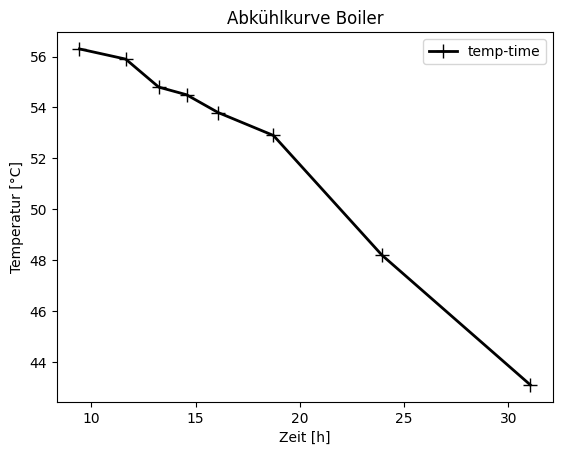

In [176]:
time_abkuehl_s   = np.array([9+26/60 , 11+39/60, 13+14/60, 14+34/60, 16+5/60, 18+44/60, 23+56/60, 31+3/60])*3600.
temp_abkuehl_deg = np.array([56.3, 55.9, 54.8, 54.5, 53.8, 52.9, 48.2, 43.1])
V_abkuehl_l     = np.array([5,5,6,5,5,5,5,5])

plt.plot(time_abkuehl_s/60./60.,temp_abkuehl_deg,color='#000000',linestyle='-',linewidth=2,marker='+',markersize=10,label='temp-time')

plt.title('Abkühlkurve Boiler')
plt.xlabel('Zeit [h]')
plt.ylabel('Temperatur [°C]')
plt.legend()
plt.show()

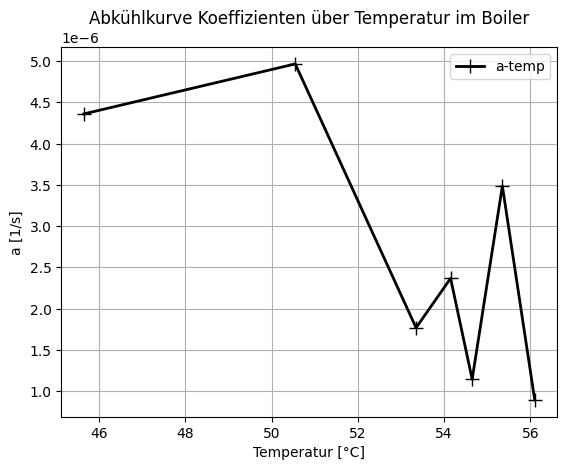

In [177]:

dtemp_abkuehl_vec = np.empty(shape=(time_abkuehl_s.size, 1), dtype=float)
dtemp_abkuehl_kor_vec = np.empty(shape=(time_abkuehl_s.size, 1), dtype=float)
temp_abkuehl_kor_vec= np.empty(shape=(time_abkuehl_s.size, 1), dtype=float)
a_abkuehl_vec= np.empty(shape=(time_abkuehl_s.size-1, 1), dtype=float)
temp_abkuehl_vec= np.empty(shape=(time_abkuehl_s.size-1, 1), dtype=float)

temp_abkuehl_kor_vec[0] = temp_abkuehl_deg[0]

for i in range(1,time_abkuehl_s.size):

  delta_temp = temp_abkuehl_deg[i]-temp_abkuehl_deg[i-1]
  delta_time = time_abkuehl_s[i]-time_abkuehl_s[i-1]
  dtemp_abkuehl_vec[i] = delta_temp/delta_time
  temp_abkuehl_vec[i-1] = (0.5 * (temp_abkuehl_deg[i]+temp_abkuehl_deg[i-1]))
  a_abkuehl_vec[i-1] = dtemp_abkuehl_vec[i] / (-temp_abkuehl_vec[i-1])


  # Mischtemperatur mit 13 °C
  temp_abkuehl_kor_vec[i-1] = (75./80*temp_abkuehl_deg[i-1]+V_abkuehl_l[i-1]/80*temp_wand)

  delta_kor_temp   = temp_abkuehl_deg[i]-temp_abkuehl_kor_vec[i-1]
  dtemp_abkuehl_kor_vec[i-1] = delta_kor_temp/delta_time

temp_abkuehl_kor_vec[-1] = temp_abkuehl_kor_vec[-2]
plt.plot(temp_abkuehl_vec,a_abkuehl_vec,color='#000000',linestyle='-',linewidth=2,marker='+',markersize=10,label='a-temp')

plt.title('Abkühlkurve Koeffizienten über Temperatur im Boiler')
plt.xlabel('Temperatur [°C]')
plt.ylabel('a [1/s]')
plt.grid()
plt.legend()
plt.show()

In [178]:
n = time_abkuehl_s.size-1
y = np.empty(shape=(n, 1), dtype=float)
A = np.empty(shape=(n, 1), dtype=float)
x = np.empty(shape=(2, 1), dtype=float)

for i in range(0,n):
  y[i] = dtemp_abkuehl_vec[i]
  A[i] = -(temp_abkuehl_deg[i])


B = A.conj().transpose()
AA = B @ A
yy = B @ y
x = np.linalg.lstsq(AA, yy, rcond=None)

x = np.linalg.inv(AA) @ yy

a_abkuehl = x[0][0]


print("dT/dt(t) + a_abkuehl * T(t) = 0")
print("------------------------------")
print(f"a_abkuehl = {a_abkuehl}")
print("------------------------------")

dT/dt(t) + a_abkuehl * T(t) = 0
------------------------------
a_abkuehl = 2.0101278094077668e-06
------------------------------


StateSpaceContinuous(
array([[-3.4e-06]]),
array([[-3.12571908e-06]]),
array([[1]]),
array([[0]]),
dt: None
)


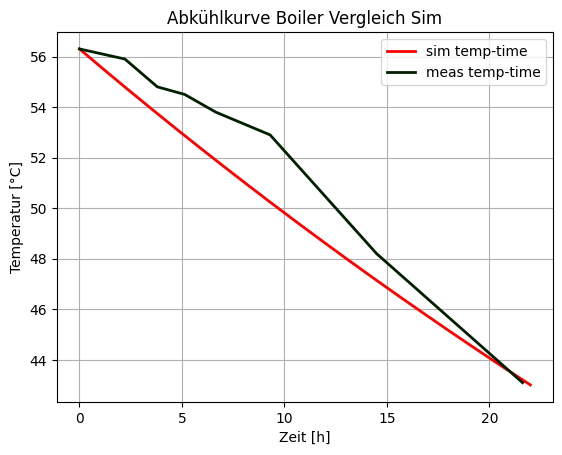

In [179]:

#
# dT/dt = -a * T(t) + b * P(t)
#

a = 3.4e-6
b = 3.1257190807128296e-06

A = -a # np.array([[0, 1], [0, 0]])
B = -b # np.array([[0], [1]])
C = 1 # np.array([[1, 0]])
D = 0 # np.array([[0]])

sys = signal.StateSpace(A, B, C, D)
print(sys)
t_end = 22*60*60 # sec

#time = np.linspace(0, t_end, num=int(t_end/100))
time = np.arange(0, t_end, 10)

P = np.zeros_like(time)

tout, y, x = signal.lsim(sys, U=P, T=time, X0 = temp_abkuehl_deg[0])

temp_sim2 = np.zeros_like(time_abkuehl_s)
time_mess = time_abkuehl_s-time_abkuehl_s[0]

plt.plot(tout/60./60.,y,color='r',linestyle='-',linewidth=2,label='sim temp-time')
plt.plot(time_mess/60./60.,temp_abkuehl_deg,color='#002000',linestyle='-',linewidth=2,label='meas temp-time')

plt.title('Abkühlkurve Boiler Vergleich Sim')
plt.xlabel('Zeit [h]')
plt.ylabel('Temperatur [°C]')
plt.grid()
plt.legend()
plt.show()